In [ ]:
# ============================================================
# 2. Montar Drive y definir rutas
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import random
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ---- RUTAS (ajusta si el nombre de las carpetas cambia) ----
ROOT_DIR = "/content/drive/MyDrive/proyecto_escoliosis_MAIA"
IMG_DIR = os.path.join(ROOT_DIR, "Radiografías")          # radiografías S_XX.jpg
COCO_JSON_PATH = os.path.join(ROOT_DIR, "Anotaciones vértebras/coco_anotaciones_actualizadas_23sep.json")

MODELS_DIR = os.path.join(ROOT_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

print("ROOT_DIR:", ROOT_DIR)
print("IMG_DIR:", IMG_DIR)
print("COCO_JSON_PATH:", COCO_JSON_PATH)
print("MODELS_DIR:", MODELS_DIR)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT_DIR: /content/drive/MyDrive/proyecto_escoliosis_MAIA
IMG_DIR: /content/drive/MyDrive/proyecto_escoliosis_MAIA/Radiografías
COCO_JSON_PATH: /content/drive/MyDrive/proyecto_escoliosis_MAIA/Anotaciones vértebras/coco_anotaciones_actualizadas_23sep.json
MODELS_DIR: /content/drive/MyDrive/proyecto_escoliosis_MAIA/models


In [ ]:
# ============================================================
# 3. Cargar COCO y preparar índices
# ============================================================

with open(COCO_JSON_PATH, "r") as f:
    coco = json.load(f)

print("Claves COCO:", coco.keys())
print("N imágenes:", len(coco.get("images", [])))
print("N anotaciones:", len(coco.get("annotations", [])))

# En tu JSON las imágenes tienen 'toras_path' como '/S_21.jpg', etc.
# y las anotaciones traen 'name' = 'F' | 'V' | 'T1'. :contentReference[oaicite:1]{index=1}

# Definimos las clases explícitamente (orden = índices del modelo)
CLASSES = ["F", "V", "T1"]  # 0=fondo, 1=columna, 2=T1
label2id = {c: i for i, c in enumerate(CLASSES)}
id2label = {i: c for i, c in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

# Mapear id de imagen -> info
imgid2info = {img["id"]: img for img in coco["images"]}

# Agrupar anotaciones por imagen
anns_by_img = defaultdict(list)
for a in coco["annotations"]:
    anns_by_img[a["image_id"]].append(a)

print("Ejemplo de imagen:", next(iter(imgid2info.values())))
print("Ejemplo de anotación:", coco["annotations"][0])



Claves COCO: dict_keys(['images', 'categories', 'annotations'])
N imágenes: 184
N anotaciones: 564
Ejemplo de imagen: {'id': 0, 'toras_path': '/S_21.jpg'}
Ejemplo de anotación: {'bbox': [126.37, 162.49, 58.599999999999994, 33.66], 'id': 0, 'image_id': 0, 'category_id': 0, 'name': 'T1', 'segmentation': [[149.07, 170.47, 156.97, 170.47, 162.97, 169.78, 168.67, 167.87, 173.19, 165.73, 176.41, 164.01, 178.75, 162.9, 181.45, 162.49, 183.4, 163.41, 184.31, 165.52, 183.97, 170.23, 184.17, 175.57, 184.47, 180.97, 184.97, 185.55, 184.78, 187.91, 183.57, 189.45, 181.78, 190.51, 176.52, 192.53, 173.47, 193.35, 170.07, 193.65, 166.47, 193.85, 162.38, 194.05, 157.57, 194.55, 152.97, 194.95, 146.47, 195.35, 140.38, 196.15, 137.78, 196.05, 136.07, 195.35, 133.38, 192.05, 130.27, 186.37, 128.07, 181.35, 126.38, 174.51, 126.37, 171.9, 127.48, 170.61, 129, 169.98, 130.93, 169.33, 139.07, 170.05]]}


In [ ]:
# ============================================================
# Filtrar COCO para usar solo imágenes que existan en Radiografías
# ============================================================
import os

# Archivos que realmente existen en la carpeta de radiografías
available_files = set(os.listdir(IMG_DIR))

def get_coco_img_name(img):
    # mismo criterio que usamos en el Dataset
    return img.get("toras_path", img.get("file_name", "")).lstrip("/")

valid_images = []
valid_img_ids = set()
missing = []

for img in coco["images"]:
    name = get_coco_img_name(img)
    if name in available_files:
        valid_images.append(img)
        valid_img_ids.add(img["id"])
    else:
        missing.append(name)

print("Imágenes en COCO original:", len(coco["images"]))
print("Imágenes con archivo real en Radiografías:", len(valid_images))
print("Algunas imágenes faltantes en disco:", missing[:10])

# Filtrar anotaciones para que solo queden las de imágenes válidas
valid_annotations = [ann for ann in coco["annotations"] if ann["image_id"] in valid_img_ids]

coco["images"] = valid_images
coco["annotations"] = valid_annotations

print("Anotaciones después de filtrar:", len(coco["annotations"]))


Imágenes en COCO original: 184
Imágenes con archivo real en Radiografías: 174
Algunas imágenes faltantes en disco: ['N_25.jpg', 'N_26.jpg', 'N_27.jpg', 'N_28.jpg', 'N_29.jpg', 'N_30.jpg', 'N_31.jpg', 'N_36.jpg', 'N_37.jpg', 'N_38.jpg']
Anotaciones después de filtrar: 499


In [ ]:
# ============================================================
# 4. Dataset: generación de máscara multi-clase desde polígonos
#    (sin albumentations, usando OpenCV + numpy)
# ============================================================
import cv2
import numpy as np
import random
from torch.utils.data import Dataset

IMG_HEIGHT = 512   # como antes
IMG_WIDTH  = 256

def resize_img_mask(img_rgb, mask, height, width):
    img_resized = cv2.resize(img_rgb, (width, height), interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    return img_resized, mask_resized

def random_flip(img_rgb, mask):
    if random.random() < 0.5:
        img_rgb = np.ascontiguousarray(img_rgb[:, ::-1, :])
        mask    = np.ascontiguousarray(mask[:, ::-1])
    return img_rgb, mask

class SpineT1Dataset(Dataset):
    def __init__(self, coco, img_root, image_ids, train=True):
        self.coco = coco
        self.img_root = img_root
        self.image_ids = image_ids
        self.train = train

        self.imgid2info = {img["id"]: img for img in coco["images"]}
        self.anns_by_img = defaultdict(list)
        for a in coco["annotations"]:
            self.anns_by_img[a["image_id"]].append(a)

    def __len__(self):
        return len(self.image_ids)

    def _build_mask(self, img_id, h, w):
        mask = np.zeros((h, w), dtype=np.uint8)
        for ann in self.anns_by_img.get(img_id, []):
            name = ann.get("name")
            if name not in label2id:
                continue
            cls_id = label2id[name]
            seg = ann.get("segmentation", [])
            if not seg:
                continue

            if isinstance(seg, dict):
                # ignoramos RLE en este modelo
                continue

            if isinstance(seg[0], (int, float)):
                seg = [seg]

            for poly in seg:
                if not poly or len(poly) < 6:
                    continue
                pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
                if pts.shape[0] < 3:
                    continue
                pts = pts.astype(np.int32)
                try:
                    cv2.fillPoly(mask, [pts], cls_id)
                except cv2.error:
                    continue
        return mask

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        info = self.imgid2info[img_id]

        img_name = info.get("toras_path", info.get("file_name", "")).lstrip("/")
        img_path = os.path.join(self.img_root, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"No se pudo leer {img_path}")

        h, w = img.shape[:2]
        mask = self._build_mask(img_id, h, w)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Resize fijo
        img_rgb, mask = resize_img_mask(img_rgb, mask, IMG_HEIGHT, IMG_WIDTH)

        # Augmentations sencillas
        if self.train:
            img_rgb, mask = random_flip(img_rgb, mask)

        img_rgb = img_rgb.astype(np.float32) / 255.0
        img_rgb = np.transpose(img_rgb, (2, 0, 1))   # C,H,W
        mask = mask.astype(np.int64)

        return torch.from_numpy(img_rgb), torch.from_numpy(mask)



In [ ]:
# ============================================================
# 5. Crear splits de train / val (y opcional test)
# ============================================================
all_img_ids = [img["id"] for img in coco["images"]]

random.seed(42)
random.shuffle(all_img_ids)

n_total = len(all_img_ids)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
# el resto como test (no lo usamos pero lo dejamos preparado)
train_ids = all_img_ids[:n_train]
val_ids   = all_img_ids[n_train:n_train + n_val]
test_ids  = all_img_ids[n_train + n_val:]

print(f"Total: {n_total}  | train: {len(train_ids)}  | val: {len(val_ids)}  | test: {len(test_ids)}")

# OJO: ahora usamos train=True / False en vez de transform=...
train_ds = SpineT1Dataset(coco, IMG_DIR, train_ids, train=True)
val_ds   = SpineT1Dataset(coco, IMG_DIR, val_ids,   train=False)

# Probar un ejemplo visualmente
img_tensor, mask_tensor = train_ds[0]
print("Img shape:", img_tensor.shape, "Mask shape:", mask_tensor.shape)


Total: 174  | train: 121  | val: 26  | test: 27
Img shape: torch.Size([3, 512, 256]) Mask shape: torch.Size([512, 256])


In [ ]:
# ============================================================
# 6. Definir modelo UNet pequeño
# ============================================================
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch),
        )

    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # in_ch = canales DESPUÉS de concatenar; la parte "profunda" tiene in_ch//2
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        # x1: features profundos (in_ch//2 canales)
        # x2: skip connection (in_ch//2 canales)
        x1 = self.up(x1)

        # ajustar tamaño si hay pequeña diferencia por divisibilidad
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2]
        )

        x = torch.cat([x2, x1], dim=1)  # ahora tiene in_ch canales
        return self.conv(x)

class DeepLabSpineT1(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # Modelo base; usamos pretrained=False para evitar problemas de versión.
        # Si más adelante quieres probar preentrenado, se puede cambiar.
        self.model = deeplabv3_resnet50(pretrained=False)

        # Reemplazar la cabeza de clasificación por una con num_classes salidas
        self.model.classifier = DeepLabHead(2048, num_classes)
        self.model.aux_classifier = None  # no usamos salida auxiliar

    def forward(self, x):
        out = self.model(x)["out"]  # torchvision devuelve un dict
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = DeepLabSpineT1(num_classes=NUM_CLASSES).to(device)

for m in model.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        m.eval()
        # opcional: congelar los parámetros de BatchNorm
        for param in m.parameters():
            param.requires_grad = False

Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# ============================================================
# 7. Función de pérdida (CE + Dice) y métrica IoU
# ============================================================
def dice_loss(logits, targets, num_classes, eps=1e-6):
    """
    Dice sobre todas las clases excepto el fondo (clase 0).
    """
    probs = torch.softmax(logits, dim=1)
    targets_onehot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    dims = (0, 2, 3)
    intersection = torch.sum(probs * targets_onehot, dims)
    cardinality  = torch.sum(probs + targets_onehot, dims)
    dice = (2.0 * intersection + eps) / (cardinality + eps)

    # ignorar fondo (índice 0)
    dice_fg = dice[1:]
    return 1.0 - dice_fg.mean()

class CombinedLoss(nn.Module):
    def __init__(self, num_classes, ce_w=0.6, dice_w=0.4, class_weights=None):
        super().__init__()
        self.ce_w = ce_w
        self.dice_w = dice_w
        self.ce = nn.CrossEntropyLoss(weight=class_weights)
        self.num_classes = num_classes

    def forward(self, logits, targets):
        ce = self.ce(logits, targets)
        d  = dice_loss(logits, targets, self.num_classes)
        return self.ce_w * ce + self.dice_w * d

# Pesos de clase para combatir el desbalance F >> V/T1 (ajusta si quieres)
class_weights = torch.tensor([0.05, 1.0, 3.0], dtype=torch.float32).to(device)

criterion = CombinedLoss(NUM_CLASSES, ce_w=0.6, dice_w=0.4, class_weights=class_weights)

def update_iou_stats(stats, preds, targets, num_classes):
    for cls in range(num_classes):
        pred_c = (preds == cls)
        targ_c = (targets == cls)
        inter = (pred_c & targ_c).sum().item()
        union = (pred_c | targ_c).sum().item()
        stats["inter"][cls] += inter
        stats["union"][cls] += union

def compute_iou_from_stats(stats):
    ious = []
    for cls in range(len(stats["inter"])):
        inter = stats["inter"][cls]
        union = stats["union"][cls]
        if union == 0:
            iou = float("nan")
        else:
            iou = inter / (union + 1e-7)
        ious.append(iou)
    return ious

In [ ]:
# ============================================================
# 8. Dataloaders y bucle de entrenamiento
# ============================================================
BATCH_SIZE = 4
EPOCHS = 50
LR = 3e-4

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, drop_last=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_val_t1_iou = 0.0
best_model_path = os.path.join(MODELS_DIR, "model_spine_t1_deeplabv3.pth")

for epoch in range(1, EPOCHS + 1):
    # ------- TRAIN -------
    model.train()
    train_loss = 0.0
    train_stats = {"inter": [0]*NUM_CLASSES, "union": [0]*NUM_CLASSES}

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

        preds = torch.argmax(logits, dim=1)
        update_iou_stats(train_stats, preds.cpu(), masks.cpu(), NUM_CLASSES)

    train_loss /= len(train_loader.dataset)
    train_ious = compute_iou_from_stats(train_stats)
    train_miou = np.nanmean(train_ious[1:])  # IoU promedio sin fondo

    # ------- VALIDATION -------
    model.eval()
    val_loss = 0.0
    val_stats = {"inter": [0]*NUM_CLASSES, "union": [0]*NUM_CLASSES}

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = criterion(logits, masks)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(logits, dim=1)
            update_iou_stats(val_stats, preds.cpu(), masks.cpu(), NUM_CLASSES)

    val_loss /= len(val_loader.dataset)
    val_ious = compute_iou_from_stats(val_stats)
    val_miou = np.nanmean(val_ious[1:])  # IoU promedio sin fondo

    # IoU de T1 explícito
    t1_idx = label2id["T1"]   # debería ser 2
    val_t1_iou = val_ious[t1_idx]

    scheduler.step()

    print(f"Epoch [{epoch}/{EPOCHS}] "
          f"TrainLoss: {train_loss:.4f}  ValLoss: {val_loss:.4f}  "
          f"Train mIoU(no F): {train_miou:.4f}  Val mIoU(no F): {val_miou:.4f}")
    print("  Train IoU por clase:")
    for cid, iou in enumerate(train_ious):
        print(f"    {cid} ({id2label[cid]}): {iou:.3f}")
    print("  Val IoU por clase:")
    for cid, iou in enumerate(val_ious):
        print(f"    {cid} ({id2label[cid]}): {iou:.3f}")

    # guardar mejor modelo
    if val_t1_iou > best_val_t1_iou:
        best_val_t1_iou = val_t1_iou
        torch.save(model.state_dict(), best_model_path)
        print(f"  -> Nuevo mejor modelo (T1 IoU={val_t1_iou:.3f}) guardado en {best_model_path}")

print("Entrenamiento terminado. Mejor mIoU val (sin fondo):", best_val_t1_iou)

Epoch [1/50] TrainLoss: 0.6076  ValLoss: 0.5413  Train mIoU(no F): 0.1707  Val mIoU(no F): 0.2625
  Train IoU por clase:
    0 (F): 0.705
    1 (V): 0.319
    2 (T1): 0.022
  Val IoU por clase:
    0 (F): 0.825
    1 (V): 0.410
    2 (T1): 0.115
  -> Nuevo mejor modelo (T1 IoU=0.115) guardado en /content/drive/MyDrive/proyecto_escoliosis_MAIA/models/model_spine_t1_deeplabv3.pth
Epoch [2/50] TrainLoss: 0.4174  ValLoss: 0.3745  Train mIoU(no F): 0.3880  Val mIoU(no F): 0.4766
  Train IoU por clase:
    0 (F): 0.914
    1 (V): 0.540
    2 (T1): 0.236
  Val IoU por clase:
    0 (F): 0.918
    1 (V): 0.582
    2 (T1): 0.371
  -> Nuevo mejor modelo (T1 IoU=0.371) guardado en /content/drive/MyDrive/proyecto_escoliosis_MAIA/models/model_spine_t1_deeplabv3.pth
Epoch [3/50] TrainLoss: 0.3307  ValLoss: 0.3332  Train mIoU(no F): 0.4879  Val mIoU(no F): 0.4550
  Train IoU por clase:
    0 (F): 0.933
    1 (V): 0.605
    2 (T1): 0.371
  Val IoU por clase:
    0 (F): 0.916
    1 (V): 0.578
    2 (T1)

In [ ]:
classes_json = {
    "id2label": id2label,     # {0: "F", 1: "V", 2: "T1"}
    "label2id": label2id,     # {"F": 0, "V": 1, "T1": 2}
    "num_classes": NUM_CLASSES,
    "img_size": [IMG_HEIGHT, IMG_WIDTH],
    "notes": "0=Fondo, 1=Columna(V), 2=Vértebra T1"
}

classes_json_path = os.path.join(MODELS_DIR, "spine_t1_classes.json")
with open(classes_json_path, "w") as f:
    json.dump(classes_json, f, indent=2, ensure_ascii=False)

print("Modelo:", best_model_path)
print("Clases:", classes_json_path)

Modelo: /content/drive/MyDrive/proyecto_escoliosis_MAIA/models/model_spine_t1_deeplabv3.pth
Clases: /content/drive/MyDrive/proyecto_escoliosis_MAIA/models/spine_t1_classes.json


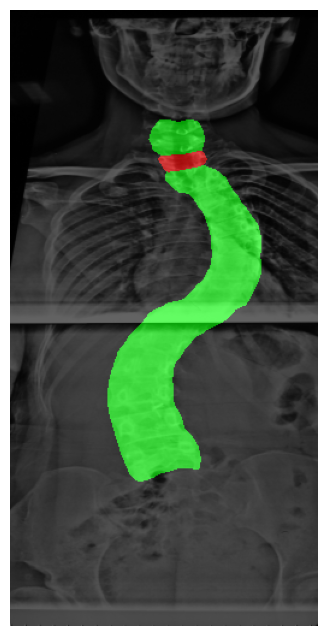

In [ ]:
# Cargar el mejor modelo
best_model = DeepLabSpineT1(num_classes=NUM_CLASSES).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

# Ejemplo con una imagen del val_ds
img_t, mask_t = val_ds[0]
with torch.no_grad():
    logits = best_model(img_t.unsqueeze(0).to(device))
    pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu()

# Overlay para ver columna (V) y T1 en colores
def overlay_segmentation(img_t, mask_pred, alpha=0.6):
    img = img_t.numpy().transpose(1, 2, 0)
    mask = mask_pred.numpy()

    colors = {
        0: (0, 0, 0),   # Fondo
        1: (0, 1, 0),   # Columna (verde)
        2: (1, 0, 0),   # T1 (rojo)
    }

    color_mask = np.zeros_like(img)
    for cid, c in colors.items():
        color_mask[mask == cid] = c

    overlay = (1 - alpha) * img + alpha * color_mask

    plt.figure(figsize=(4, 8))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

overlay_segmentation(img_t, pred_mask)